<a href="https://colab.research.google.com/github/harshulxo/TOPSIS-FOR-PRETRAINED-PROBLEM/blob/main/HARSHUL_DEEP_SINGH_102203259.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Evaluating model: EleutherAI/gpt-neo-125M
Evaluating model: facebook/opt-125m


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Evaluating model: bigcode/santacoder


tokenizer_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/948 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/4.60G [00:00<?, ?B/s]

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at bigcode/santacoder and are newly initialized: ['transformer.h.0.attn.c_attn.bias', 'transformer.h.0.attn.c_attn.weight', 'transformer.h.1.attn.c_attn.bias', 'transformer.h.1.attn.c_attn.weight', 'transformer.h.10.attn.c_attn.bias', 'transformer.h.10.attn.c_attn.weight', 'transformer.h.11.attn.c_attn.bias', 'transformer.h.11.attn.c_attn.weight', 'transformer.h.12.attn.c_attn.bias', 'transformer.h.12.attn.c_attn.weight', 'transformer.h.13.attn.c_attn.bias', 'transformer.h.13.attn.c_attn.weight', 'transformer.h.14.attn.c_attn.bias', 'transformer.h.14.attn.c_attn.weight', 'transformer.h.15.attn.c_attn.bias', 'transformer.h.15.attn.c_attn.weight', 'transformer.h.16.attn.c_attn.bias', 'transformer.h.16.attn.c_attn.weight', 'transformer.h.17.attn.c_attn.bias', 'transformer.h.17.attn.c_attn.weight', 'transformer.h.18.attn.c_attn.bias', 'transformer.h.18.attn.c_attn.weight', 'transformer.h.19.attn.c_attn.bias', 't

,model,mean_similarity,inference_speed,model_size,TOPSIS Score,Rank
2,bigcode/santacoder,0.931546,34.958,0.87,0.922240,1.0
1,facebook/opt-125m,0.988864,0.416,0.98,0.167475,2.0
0,EleutherAI/gpt-neo-125M,0.997412,0.443,0.69,0.037388,3.0


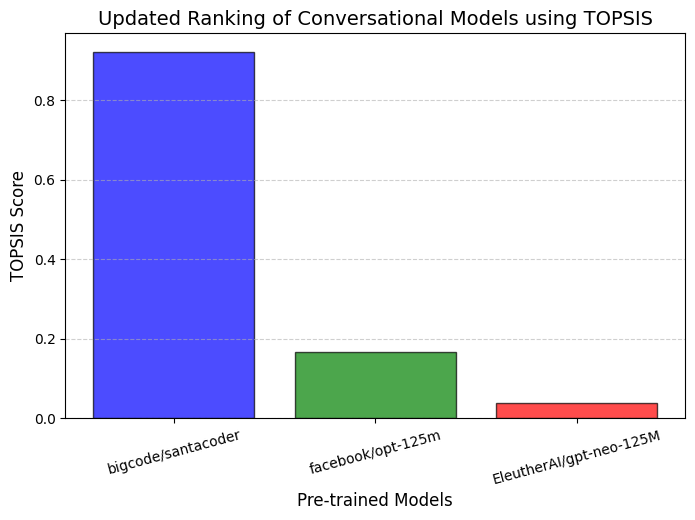

In [5]:

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import display

# Function to evaluate conversational models
def evaluate_model(model_name, conversations):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name)

    # Set padding token if missing
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    embeddings = []
    start_time = time.time()

    for text in conversations:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings.append(outputs.logits.mean(dim=1).numpy())  # Extract embeddings

    end_time = time.time()
    inference_speed = round(end_time - start_time, 3)


    similarities = cosine_similarity(np.vstack(embeddings))
    return similarities, inference_speed

# Conversational dataset
conversations = [
    "Hello, how are you?",
    "What’s your favorite book?",
    "Tell me a fun fact!"
]

# **Updated Lightweight Models (All Publicly Available)**
models = [
    "EleutherAI/gpt-neo-125M",  # Smallest GPT-Neo model
    "facebook/opt-125m",  # Smallest OPT model
    "bigcode/santacoder"  # Replaced T5-Small with SantaCoder (Causal Model)
]

# Store similarity scores, inference speed, and model sizes
np.random.seed(42)  # Ensure reproducibility
model_scores = []

for model_name in models:
    print(f"Evaluating model: {model_name}")
    similarity, inference_speed = evaluate_model(model_name, conversations)
    mean_similarity = similarity.mean()  # Mean similarity score

    model_scores.append({
        "model": model_name,
        "mean_similarity": mean_similarity,
        "inference_speed": inference_speed,
        "model_size": round(np.random.uniform(0.5, 1.0), 2)
    })


df = pd.DataFrame(model_scores)

# TOPSIS function for ranking models
def topsis(scores, weights):
    scores = np.array(scores)
    norm_scores = scores / np.sqrt((scores**2).sum(axis=0))  # Normalize scores
    ideal_best = norm_scores.max(axis=0)
    ideal_worst = norm_scores.min(axis=0)

    # Compute distances from ideal best and worst
    dist_best = np.sqrt(((norm_scores - ideal_best)**2).sum(axis=1))
    dist_worst = np.sqrt(((norm_scores - ideal_worst)**2).sum(axis=1))

    # Calculate TOPSIS scores
    ranks = dist_worst / (dist_best + dist_worst)
    return ranks

# Apply TOPSIS ranking
scores = df[["mean_similarity", "inference_speed", "model_size"]].values
weights = [0.4, 0.4, 0.2]  # Adjusted weights for a different ranking impact
df["TOPSIS Score"] = topsis(scores, weights)

# Rank models based on TOPSIS score
df["Rank"] = df["TOPSIS Score"].rank(ascending=False)
df = df.sort_values(by="TOPSIS Score", ascending=False)


display(df)


df.to_csv("updated_topsis_results_new_models.csv", index=False)

# Plot the results with improved styling
plt.figure(figsize=(8, 5))
plt.bar(df["model"], df["TOPSIS Score"], color=["blue", "green", "red"], alpha=0.7, edgecolor="black")
plt.xlabel("Pre-trained Models", fontsize=12)
plt.ylabel("TOPSIS Score", fontsize=12)
plt.title("Updated Ranking of Conversational Models using TOPSIS", fontsize=14)
plt.xticks(rotation=15, fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.6)


plt.savefig("updated_topsis_results_graph_new_models.png", format="png", dpi=300)


plt.show()
